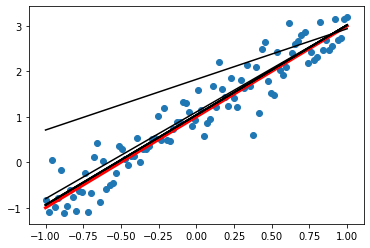

In [1]:
import tensorflow as tf
import numpy as np  # Python的一种开源的数值计算扩展
import matplotlib.pyplot as plt  # Python的一种绘图库

np.random.seed(5)  # 设置产生伪随机数的类型
sx = np.linspace(-1, 1, 100)  # 在-1到1之间产生100个等差数列作为图像的横坐标
# 根据y=2*x+1+噪声产生纵坐标
# randn(100)表示从100个样本的标准正态分布中返回一个样本值，0.4为数据抖动幅度
sy = 2 * sx + 1.0 + np.random.randn(100) * 0.4

plt.scatter(sx, sy)  # 生成散点图
plt.plot(sx, 2 * sx + 1, color='red', linewidth=3)  # 生成直线y=2x+1

# plt.show()

# 定义函数模型，y=kx+b
# def model(x, k, b):
#     print("==============",x.dtype,k.dtype)
#     x = tf.cast(x,dtype=tf.float32)
#     return tf.multiply(k, x) + b


# 定义模型中的参数变量，并为其赋初值
k = tf.Variable(1.0, name='k')
b = tf.Variable(0, name='b',dtype=tf.float32)

# 定义训练数据的占位符，x为特征值，y为标签
x = tf.placeholder(dtype=tf.float32,name='x')
y = tf.placeholder(dtype=tf.float32,name='y')
# 通过模型得出特征值x对应的预测值yp
yp = tf.add(tf.multiply(x, k), b, name='yp')
# 训练模型，设置训练参数(迭代次数、学习率)
train_epoch = 10
rate = 0.05
# 定义均方差为损失函数
loss = tf.reduce_mean(tf.square(y - yp))
# 定义梯度下降优化器，并传入参数学习率和损失函数
optimizer = tf.train.GradientDescentOptimizer(rate).minimize(loss)

saver = tf.train.Saver()


ss = tf.Session()
init = tf.global_variables_initializer()
ss.run(init)

# 进行多轮迭代训练，每轮将样本值逐个输入模型，进行梯度下降优化操作得出参数，绘制模型曲线
for _ in range(train_epoch):
    for x1, y1 in zip(sx, sy):
        ss.run([optimizer, loss], feed_dict={x: x1, y: y1})
    tmp_k = k.eval(session=ss)
    tmp_b = b.eval(session=ss)
    plt.plot(sx, tmp_k * sx + tmp_b,color='black')
    # Save the variables to disk.
    save_path = saver.save(ss, "/tmp/tf4/kx_lines.ckpt")

ss.close()
plt.show()

In [2]:
tf.reset_default_graph()

# def model(x, k, b):
#     print("==============",x.dtype,k.dtype)
#     x = tf.cast(x,dtype=tf.float32)
#     return tf.multiply(k, x) + b


# 定义模型中的参数变量，并为其赋初值
k = tf.Variable(1.0, name='k')
b = tf.Variable(0, name='b',dtype=tf.float32)


# 定义训练数据的占位符，x为特征值，y为标签
x = tf.placeholder(dtype=tf.float32,name='x')
# yp = model(x, k, b)
# 训练模型，设置训练参数(迭代次数、学习率)
# train_epoch = 10
# rate = 0.05
# 定义均方差为损失函数
# loss = tf.reduce_mean(tf.square(y - yp))
# 定义梯度下降优化器，并传入参数学习率和损失函数
# optimizer = tf.train.GradientDescentOptimizer(rate).minimize(loss)
yp = tf.add(tf.multiply(x, k), b, name='yp')
sy = 2 * sx + 1.0 + np.random.randn(100) * 0.4
saver = tf.train.Saver()
sess = tf.Session()

# Restore variables from disk.
saver.restore(sess, "/tmp/tf4/kx_lines.ckpt")
print("Model restored.")
print("k : %s" % k.eval(session=sess))
print("b : %s" % b.eval(session=sess))

INFO:tensorflow:Restoring parameters from /tmp/tf4/kx_lines.ckpt
Model restored.
k : 1.9822965
b : 1.0420128


In [7]:
sess


In [8]:
def predict4(sess, inputs):
    preds = sess.run("yp:0" ,feed_dict={"x:0": inputs}) 
    # `X` is used, it must be defined in the model with that name explicitly!
    return [str(p) for p in preds]

In [9]:
from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [10]:
clipper_conn.start_clipper()

20-03-18:05:15:17 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-03-18:05:15:22 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmp111ev1w5.yml
20-03-18:05:15:23 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [11]:
clipper_conn.connect()

20-03-18:05:15:37 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [12]:
clipper_conn.register_application(
    name="tf-app40", input_type="doubles", default_output="-1.0", slo_micros=100000)

20-03-18:05:16:05 INFO     [clipper_admin.py:236] [default-cluster] Application tf-app40 was successfully registered


In [13]:
deploy_tensorflow_model(
    clipper_conn,
    name="tf-mod4",
    version=1,
    input_type="doubles",
    func=predict4,
    tf_sess_or_saved_model_path="/tmp/tf4/") # path to saved model files is used,

20-03-18:05:17:02 INFO     [deployer_utils.py:41] Saving function to /tmp/tmp5noh4o_3clipper
20-03-18:05:17:02 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-03-18:05:17:02 INFO     [tensorflow.py:264] TensorFlow model copied to: tfmodel 
20-03-18:05:17:02 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-03-18:05:17:02 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmp5noh4o_3clipper
20-03-18:05:17:03 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-03-18:05:17:03 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-03-18:05:17:03 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmp5noh4o_3clipper /model/
20-03-18:05:17:03 INFO     [clipper_admin.py:539] [default-cluster]  ---> 8982e29c42a2
20-03-18:05:17:03 INFO     [clipper_admin.py:539] [default-cluster] Successfully built 8982e29c42a2
20-03-18:05:1

In [15]:
clipper_conn.link_model_to_app(
    app_name="tf-app40",
    model_name="tf-mod4")

20-03-18:05:17:46 INFO     [clipper_admin.py:303] [default-cluster] Model tf-mod4 is now linked to application tf-app40


In [16]:
query_address = clipper_conn.get_query_addr()

In [17]:
print(query_address)

localhost:1337


In [18]:
import requests, json, numpy as np
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app40/predict", headers=headers, data=json.dumps({
    "input": [.8,1.2]})).json()

{'query_id': 0, 'output': '[2.62785   3.4207687]', 'default': False}

In [1]:
clipper_conn.stop_all()

NameError: name 'clipper_conn' is not defined